# Two-Stage
This method is performed in two parts. Firstly, it is estimated each cell individually using a MLE model, therefore an array of #Cellx#parameters is created. From that set of parameters, then, it is calculated the population mean and a covarinve matrix. Those statistics are used to genered a new inferred population and compare it to the observations used during parameter estimation.

In [1]:
#libraries requiered
import numpy as np
import matplotlib.pyplot as plt
import simsysbio as s2b
from scipy.optimize import fmin

## Load data
First, it is loaded a population previously simulated from extrinsic variability.

In [2]:
#load data
npzfile = np.load('anex1_extr_ns.npz')

valReac = npzfile['valReac']
valProd = npzfile['valProd']
ecuaciones = npzfile['ecuaciones']
valPar = npzfile['vPars']
idxReaction = npzfile['idxR']
AllcellExpr = npzfile['AllcellExpr']
expTime = npzfile['Vtime']
inpShock = npzfile['inpU']

regressor = {
        "ODEs": ecuaciones,
        "matrizR": valReac,
        "matrizP": valProd,
        "vPars": valPar,
        "idxR": idxReaction,
        "species0":npzfile['species0'],
        "Vtime":npzfile['Vtime'],
        "inpU":npzfile['inpU']
        }
            
variables = {
        "species":npzfile['species'],
        "pars":npzfile['pars'],
        "nameVar":npzfile['nameVar']
        }
regressor.update(variables)

data = {
    "genExpr": AllcellExpr,
    "inPulse": inpShock,
    "vTime": expTime,
    }

In [3]:
#compute mean and standard deviation from observations
Obs = data["genExpr"][:,:,-1]


if not np.isnan(Obs).any():
    uObs = np.mean(Obs, axis=0)
    sdObs = np.std(Obs, axis=0)
else:
    uObs = np.nanmean(Obs, axis=0)
    sdObs = np.nanstd(Obs, axis=0)

In [5]:
#definition of objetive function used during parameter estimation

def MLLmeasure(Obs, fSim, hSim):
    hSim = np.absolute(hSim)    #avoid negative-zero log errors
    mll = np.sum(np.sum(0.5*(((Obs - fSim)/hSim)**2), axis=1)) + np.sum(np.sum(np.log(hSim), axis=1))
    return mll

def MLLWrap(pars, regressor):    
    nPars = pars[-2:]
    
    expr = s2b.solveODEpy(pars[:-2], regressor)
    uS = expr[-1,:]
    
    sdS = nPars[0] + nPars[1]*uS
    
    fSim = np.tile(uS, (len(regressor["Obs"]),1))
    hSim = np.tile(sdS,(len(regressor["Obs"]),1))
    
    mll = s2b.MLLmeasure(regressor["Obs"], fSim, hSim)

    return mll

## Initial parameters set up

In [7]:
GuessPars = np.array([3.0, 0.02, 0.9, 0.01, 40.0, 0.1])

#subpopulation
samplesC = 50
#rIdx = np.random.choice(Obs.shape[0], samplesC, replace= False)
rIdx = np.linspace(0, Obs.shape[0]-1, samplesC, dtype=int)
subPop = Obs[rIdx,:]

#array to store single estimated parameters
popPars = np.zeros((samplesC, len(GuessPars)-2))
popA = np.zeros(samplesC)
popB = np.zeros(samplesC)


#bnd = [(0,None)]*6
#mtd = 'Powell'
mxiter= 500

## Loop for estimating each set of parameters related to a single cell

In [8]:
for iCell in range(samplesC):
    print(iCell+1)
    regressor["Obs"] = np.array([subPop[iCell,:]])
    
    minimum = fmin(MLLWrap, GuessPars, args=(regressor,),
                                    maxiter=mxiter)
    
#    res = minimize(MLLWrap, GuessPars, method=mtd, args=(regressor,),
#                   bounds=bnd, options={'maxiter':mxiter})
#    minimum = res.x

    
    #save estimated parameters
    popPars[iCell,:] = minimum[:-2]
    popA[iCell] = minimum[-2]
    popB[iCell] = minimum[-1]

1
2
3
Optimization terminated successfully.
         Current function value: 508.516534
         Iterations: 458
         Function evaluations: 731
4
Optimization terminated successfully.
         Current function value: 504.883157
         Iterations: 393
         Function evaluations: 650
5
Optimization terminated successfully.
         Current function value: 504.743347
         Iterations: 298
         Function evaluations: 507
6
Optimization terminated successfully.
         Current function value: 496.968438
         Iterations: 436
         Function evaluations: 708
7
Optimization terminated successfully.
         Current function value: 517.210174
         Iterations: 450
         Function evaluations: 740
8
9
10
Optimization terminated successfully.
         Current function value: 488.518390
         Iterations: 402
         Function evaluations: 660
11
12
13
14
15
Optimization terminated successfully.
         Current function value: 502.249168
         Iterations: 299
     

## Compute needed statistics from estimated data

In [9]:
popAB = np.array([popA, popB])

#index0 = np.where(popPars < 0)
#todelete = index0[0].tolist()
#filPars = np.delete(popPars, todelete, axis=0)
#filAB = np.delete(popAB, todelete, axis=1)

index0 = np.where(popPars == 0)
todelete = index0[0].tolist()
filPars = np.delete(popPars, todelete, axis=0)
filAB = np.delete(popAB, todelete, axis=1)


def tsStats(parsPop, ABpop):
    #log population parameters    
    logPars = np.log(parsPop)

    #mean of log parameters
    mu = np.mean(logPars, axis=0)
    
    #covariance of log parameters
    omega = np.cov(logPars.T)

    #mean of noise parameter        
    ABpars = np.mean(ABpop, axis=1)
    
    return np.exp(mu), omega, ABpars

betacal, covPars, noiseCal = tsStats(np.absolute(filPars), np.absolute(filAB))

## Creation of new parameters distribution 

In [10]:
newMultiPars = np.exp(np.random.multivariate_normal(np.log(betacal), covPars, 
                                                    len(Obs)))

## Simulation of new inferred population

In [11]:
##############################
popExpr = np.zeros((len(Obs), len(expTime)))
##############################

for newPars in range(len(Obs)):
    cellCal = s2b.solveODEpy(newMultiPars[newPars,:], regressor)
    popExpr[newPars, :] = cellCal[-1,:]

## Addition of measurement noise

In [12]:
#normal distribution
mu, sigma = 0, 1 #mean and standard deviation
ndis = np.random.normal(mu, sigma, (len(Obs),len(expTime)))

#computes individual output with noise for each species
hvar = noiseCal[0] + noiseCal[1]*popExpr     
popExpr = popExpr + hvar*ndis

## Comparation between observed population vs inferred population

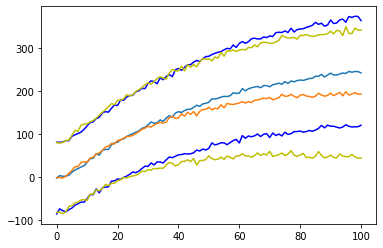

In [13]:
ucellCal = np.mean(popExpr, axis=0)
sdcellCal2 = np.std(popExpr, axis=0)

plt.figure()
plt.plot(expTime, uObs)
plt.plot(expTime, uObs+sdObs, 'b')
plt.plot(expTime, uObs-sdObs, 'b')
plt.plot(expTime, ucellCal)
plt.plot(expTime, ucellCal + sdcellCal2, 'y')
plt.plot(expTime, ucellCal-sdcellCal2, 'y')
plt.show()